# Lightgbm

In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import lightgbm

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV

from IPython.display import display

from utils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load possible outliers (Optional)

In [3]:
outliers_idx = np.load('isolation_forest_outliers.npy', mmap_mode='r')
outliers_idx = np.array(outliers_idx)

### Load data

In [3]:
train = pd.read_csv('input/train.csv')
print(train.shape)
#display(train.head(2))

(307511, 199)


In [4]:
test = pd.read_csv('input/test.csv')
print(test.shape)

(48744, 198)


Outliers removal (optional step)

In [ ]:
train = train.drop(index=train.index[outliers_idx])
train = train.reset_index(drop=True)

Removing service and target columns

In [5]:
targets = train[['TARGET']]

train_ids = train['SK_ID_CURR']
train = train.drop(columns=['SK_ID_CURR', 'TARGET'])

In [6]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

In [7]:
targets[['TARGET']].shape

(307511, 1)

### Drop redundant columns
Columns which almost identical (correlation is close to 1)

In [8]:
cols_drop = appartment_mode_cols + appartment_medi_cols
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)

In [9]:
print(train.shape)
print(test.shape)

(307511, 177)
(48744, 177)


### List Categorical Features

In [10]:
cat_features = train.select_dtypes('object').columns.tolist()

In [11]:
for col in cat_features: 
    train[col] = train[col].astype('category') 
    test[col] = test[col].astype('category') 

### Parameter Tuning

In [ ]:
model = lightgbm.LGBMClassifier(n_estimators=10000, objective='binary', 
                                    class_weight='balanced', learning_rate=0.0003, 
                                    num_leaves=31, max_depth=-1,
                                    reg_alpha=3, reg_lambda=5, 
                                    subsample=0.8, n_jobs=6, random_state=4242, device='gpu')

# x_train, x_valid, y_train, y_test = train_test_split(train, targets, train_size=0.8,
#                                                      stratify=targets, random_state=4242)

params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [8000, 16000],
    'num_leaves': [16, 32],
    'max_depth': [-1, 4, 7],
    'min_child_samples': [10, 20, 40],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'min_data_in_leaf': [8, 16, 32],
    'max_bin': [127, 255]
}

best_params = {
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 10000,
    'num_leaves': 32,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5
}

#k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rscv = RandomizedSearchCV(model, params, n_iter=20, cv=5, n_jobs=1, verbose=1)
rscv.fit(train, targets[['TARGET']], categorical_feature=cat_features,
         eval_metric='auc', verbose=100)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [27]:
rscv.best_params_

{'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'n_estimators': 10000,
 'num_leaves': 32,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5}

In [30]:
pd.DataFrame(rscv.cv_results_) #.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_min_child_samples,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,20.646780,1.090342,0.778447,0.819963,0.1,-1,50,1000,16,1,0.5,"{'max_depth': -1, 'n_estimators': 1000, 'num_l...",10,0.777604,0.819128,0.776983,0.818970,0.776755,0.820689,0.780739,0.820897,0.780153,0.820129,1.364611,0.081889,0.001666,0.000789
1,182.423434,8.375476,0.897239,0.994572,0.1,-1,20,10000,16,0.5,0.5,"{'max_depth': -1, 'n_estimators': 10000, 'num_...",2,0.896802,0.994817,0.895434,0.994179,0.898312,0.994821,0.897337,0.994155,0.898312,0.994886,1.646100,0.061407,0.001073,0.000332
2,149.858651,8.330689,0.896618,0.994084,0.1,8,100,10000,16,0.5,1,"{'max_depth': 8, 'n_estimators': 10000, 'num_l...",4,0.896086,0.993976,0.894930,0.993781,0.896833,0.994203,0.896280,0.994151,0.898963,0.994309,3.473645,0.136559,0.001326,0.000186
3,46.331426,1.646152,0.859989,0.946393,0.1,8,50,1000,64,2,2,"{'max_depth': 8, 'n_estimators': 1000, 'num_le...",8,0.860234,0.946343,0.858249,0.944949,0.858899,0.946701,0.860525,0.947173,0.862037,0.946799,1.467795,0.134409,0.001324,0.000769
4,45.315937,1.737684,0.859540,0.947362,0.1,8,50,1000,64,1,1,"{'max_depth': 8, 'n_estimators': 1000, 'num_le...",9,0.859226,0.947851,0.858005,0.946860,0.857842,0.947124,0.860590,0.947648,0.862037,0.947327,1.116316,0.022264,0.001592,0.000355
5,63.585008,1.414112,0.865979,0.957682,0.1,-1,20,1000,64,1,0.5,"{'max_depth': -1, 'n_estimators': 1000, 'num_l...",7,0.865714,0.958026,0.864964,0.957717,0.864590,0.957469,0.865956,0.957111,0.868671,0.958087,2.840698,0.102837,0.001434,0.000362
6,203.942639,9.828402,0.896765,0.994180,0.1,-1,20,10000,16,0.5,1,"{'max_depth': -1, 'n_estimators': 10000, 'num_...",3,0.896298,0.994077,0.895402,0.993927,0.896865,0.994301,0.897353,0.993947,0.897906,0.994647,1.417352,0.408427,0.000864,0.000269
7,101.930495,4.059782,0.866128,0.957481,0.1,8,20,5000,16,0.5,2,"{'max_depth': 8, 'n_estimators': 5000, 'num_le...",6,0.865291,0.957579,0.864785,0.956668,0.866265,0.957904,0.865712,0.957189,0.868590,0.958067,0.399783,0.078034,0.001323,0.000505
8,313.925770,11.454012,0.913483,1.000000,0.1,-1,20,10000,32,0.5,0.5,"{'max_depth': -1, 'n_estimators': 10000, 'num_...",1,0.914151,1.000000,0.912621,1.000000,0.912783,1.000000,0.913645,1.000000,0.914214,1.000000,7.226534,0.354123,0.000669,0.000000
9,44.760656,1.485845,0.867231,0.957291,0.1,-1,100,1000,64,0.5,0.5,"{'max_depth': -1, 'n_estimators': 1000, 'num_l...",5,0.866576,0.956327,0.865760,0.957384,0.865630,0.956083,0.868834,0.958977,0.869354,0.957684,0.784709,0.035171,0.001564,0.001039


In [32]:
print(rscv.best_index_)
rscv.best_score_

8


0.9134827697220588

### Model K-Fold Execution

In [27]:
features = np.array(train)
test_features = np.array(test)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

valid_scores = []
train_scores = []
test_predictions = np.zeros(test_features.shape[0])

for train_indices, valid_indices in k_fold.split(features, targets):
    # Numpy version
    # Training data for the fold
    #train_features, train_labels = features[train_indices], targets[train_indices]
    # Validation data for the fold
    #valid_features, valid_labels = features[valid_indices], targets[valid_indices]
    
    # DataFrame version
    train_features, train_labels = train.iloc[train_indices], targets[train_indices]
    valid_features, valid_labels = train.iloc[valid_indices], targets[valid_indices]
    test_features = test
    
    # d_train = lightgbm.Dataset(train_features, label=train_labels)
    # d_valid = lightgbm.Dataset(valid_features, label=valid_labels)
    # model = lightgbm.train(parameters, d_train, verbose_eval=100, valid_sets=[d_valid], num_boost_round=20000, early_stopping_rounds=200)
    
    # The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional
    # to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    model = lightgbm.LGBMClassifier(n_estimators=10000, objective='binary', 
                                    class_weight='balanced', learning_rate=0.0003, 
                                    num_leaves=31, max_depth=-1,
                                    reg_alpha=3, reg_lambda=5, 
                                    subsample=0.8, n_jobs=6, random_state=4242)
    
    model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

    best_iteration = model.best_iteration_
    
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.729982	valid's auc: 0.715576
[200]	train's auc: 0.734973	valid's auc: 0.720676
[300]	train's auc: 0.737764	valid's auc: 0.723392
[400]	train's auc: 0.739626	valid's auc: 0.725248
[500]	train's auc: 0.741102	valid's auc: 0.726489
[600]	train's auc: 0.742563	valid's auc: 0.727692
[700]	train's auc: 0.744073	valid's auc: 0.728838
[800]	train's auc: 0.745701	valid's auc: 0.730233
[900]	train's auc: 0.747365	valid's auc: 0.731747
[1000]	train's auc: 0.749189	valid's auc: 0.733308
[1100]	train's auc: 0.751143	valid's auc: 0.734866
[1200]	train's auc: 0.753172	valid's auc: 0.73646
[1300]	train's auc: 0.755155	valid's auc: 0.737879
[1400]	train's auc: 0.757167	valid's auc: 0.739472
[1500]	train's auc: 0.759259	valid's auc: 0.741032
[1600]	train's auc: 0.761241	valid's auc: 0.742439
[1700]	train's auc: 0.763138	valid's auc: 0.743824
[1800]	train's auc: 0.765011	valid's auc: 0.745193
[1900]	train's auc: 0.766859	

[5900]	train's auc: 0.805838	valid's auc: 0.771605
[6000]	train's auc: 0.806455	valid's auc: 0.771822
[6100]	train's auc: 0.807055	valid's auc: 0.772016
[6200]	train's auc: 0.807645	valid's auc: 0.772209
[6300]	train's auc: 0.808235	valid's auc: 0.772409
[6400]	train's auc: 0.80882	valid's auc: 0.772619
[6500]	train's auc: 0.809402	valid's auc: 0.772816
[6600]	train's auc: 0.809964	valid's auc: 0.772977
[6700]	train's auc: 0.810537	valid's auc: 0.773126
[6800]	train's auc: 0.811104	valid's auc: 0.773266
[6900]	train's auc: 0.811655	valid's auc: 0.773389
[7000]	train's auc: 0.812208	valid's auc: 0.773523
[7100]	train's auc: 0.812751	valid's auc: 0.773674
[7200]	train's auc: 0.813299	valid's auc: 0.773814
[7300]	train's auc: 0.813834	valid's auc: 0.773934
[7400]	train's auc: 0.814371	valid's auc: 0.77405
[7500]	train's auc: 0.814917	valid's auc: 0.774182
[7600]	train's auc: 0.815457	valid's auc: 0.774299
[7700]	train's auc: 0.815984	valid's auc: 0.77441
[7800]	train's auc: 0.816508	valid

[1500]	train's auc: 0.75838	valid's auc: 0.743381
[1600]	train's auc: 0.760299	valid's auc: 0.744818
[1700]	train's auc: 0.762345	valid's auc: 0.746374
[1800]	train's auc: 0.764348	valid's auc: 0.747939
[1900]	train's auc: 0.766193	valid's auc: 0.749375
[2000]	train's auc: 0.767979	valid's auc: 0.750655
[2100]	train's auc: 0.769629	valid's auc: 0.751834
[2200]	train's auc: 0.771224	valid's auc: 0.752969
[2300]	train's auc: 0.772768	valid's auc: 0.754042
[2400]	train's auc: 0.774314	valid's auc: 0.755106
[2500]	train's auc: 0.775749	valid's auc: 0.756035
[2600]	train's auc: 0.777065	valid's auc: 0.756855
[2700]	train's auc: 0.77834	valid's auc: 0.757638
[2800]	train's auc: 0.779588	valid's auc: 0.75841
[2900]	train's auc: 0.780755	valid's auc: 0.759133
[3000]	train's auc: 0.781896	valid's auc: 0.759825
[3100]	train's auc: 0.78303	valid's auc: 0.760491
[3200]	train's auc: 0.784103	valid's auc: 0.761146
[3300]	train's auc: 0.785132	valid's auc: 0.761676
[3400]	train's auc: 0.78618	valid's

[7400]	train's auc: 0.814431	valid's auc: 0.774854
[7500]	train's auc: 0.814956	valid's auc: 0.774975
[7600]	train's auc: 0.81548	valid's auc: 0.775077
[7700]	train's auc: 0.815998	valid's auc: 0.775171
[7800]	train's auc: 0.816512	valid's auc: 0.775276
[7900]	train's auc: 0.817015	valid's auc: 0.775367
[8000]	train's auc: 0.81754	valid's auc: 0.775443
[8100]	train's auc: 0.818057	valid's auc: 0.775519
[8200]	train's auc: 0.818568	valid's auc: 0.775614
[8300]	train's auc: 0.819075	valid's auc: 0.7757
[8400]	train's auc: 0.819574	valid's auc: 0.775796
[8500]	train's auc: 0.82007	valid's auc: 0.77589
[8600]	train's auc: 0.820568	valid's auc: 0.775976
[8700]	train's auc: 0.821053	valid's auc: 0.776053
[8800]	train's auc: 0.821546	valid's auc: 0.776124
[8900]	train's auc: 0.822017	valid's auc: 0.776194
[9000]	train's auc: 0.822493	valid's auc: 0.776256
[9100]	train's auc: 0.822958	valid's auc: 0.776315
[9200]	train's auc: 0.823422	valid's auc: 0.776369
[9300]	train's auc: 0.823887	valid's 

### Plots

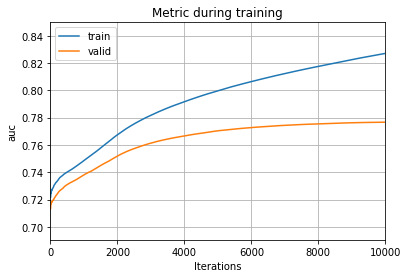

In [28]:
lightgbm.plot_metric(model)

In [ ]:
lightgbm.plot_tree(model)

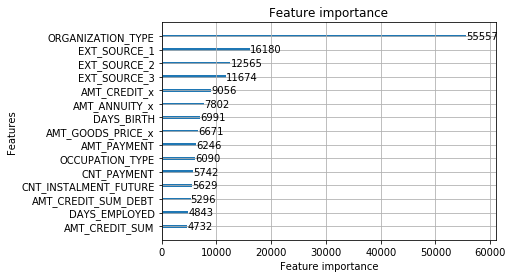

In [33]:
lightgbm.plot_importance(model, max_num_features=15)

In [44]:
model.booster_

### Submission

In [35]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
save_prediction(submission, 'lightgbm')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-lightgbm.csv -m "lightgbm"'